In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from typing import Callable, List, Optional, Union


In [3]:
!curl -L -o ./archive.zip\
https://www.kaggle.com/api/v1/datasets/download/abdullah0a/student-dropout-analysis-and-prediction-dataset

import zipfile

with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11578  100 11578    0     0   6400      0  0:00:01  0:00:01 --:--:--  6400


### CheetSheet

In [73]:
fullDataset = pd.read_csv('student dropout.csv')

In [74]:

# без спецэффектов
def categoricalToNum(dfinput : DataFrame):
    df = dfinput.copy()
    label_encoders = {}
    for col in df.select_dtypes(include=['object', 'bool']).columns:
        # if col != target_feature:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df


In [24]:
print(fullDataset.select_dtypes(include='number').shape)
print(fullDataset.shape)
print(categoricalToNum(fullDataset).select_dtypes(include='number').shape)
print(fullDataset.select_dtypes(include='number').shape)

(649, 16)
(649, 34)
(649, 34)
(649, 16)


In [86]:
# allY = fullDataset['Dropped_Out']
TARGET = 'Dropped_Out'
fullDatasetNorm = fullDataset.copy()
fullDatasetNorm = fullDatasetNorm.drop(columns=['Final_Grade', 'Grade_1', 'Grade_2'])
fullDatasetNorm = categoricalToNum(fullDatasetNorm).select_dtypes(include='number')
X_train = fullDatasetNorm.drop(columns=[TARGET])
y_train = fullDatasetNorm[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

проверка что булеаны нормально нормализовались

In [27]:
# fullDatasetNorm.iloc[:,  32] # 32я колонка
fullDatasetNorm.columns
fullDataset.loc[fullDataset[TARGET] == True][TARGET]
fullDatasetNorm.loc[fullDatasetNorm[TARGET] == 1][TARGET]

18     1
52     1
81     1
100    1
125    1
      ..
635    1
637    1
639    1
640    1
646    1
Name: Dropped_Out, Length: 100, dtype: int64

полезные функции

## Все теперь лаба

### Структура Решающее Дерево

In [79]:
class DecisionFunction:
    def __init__(self, 
                 feature: str, 
                 threshold: Union[int, float], 
                 decision: Callable[[any], bool]):
        """
        Инициализация функции решения.

        :param feature: Название признака.
        :param threshold: Пороговое значение.
        :param decision: Функция, принимающая значение признака и возвращающая решение.
        """
        self.feature = feature
        self.threshold = threshold
        self.decision = decision

    def __call__(self, observation: Series) -> any:
        """
        Вызов функции решения для одного наблюдения.

        :param observation: Series (одно наблюдение).
        :return: Решение.
        """
        return self.decision(observation)

class Node:
    def __init__(self, categories: List[any]):
        """
        Инициализация узла дерева.

        :param categories: Список всех возможных категорий.
        """
        self.categories = categories

class DecisionNode(Node):
    def __init__(self, 
                 categories: List[any], 
                 decision_function: DecisionFunction, 
                 children: Optional[dict] = None):
        """
        Инициализация узла решения.

        :param decision_function: Функция, принимающая наблюдение и возвращающая
                                  либо идентификатор ребенка (ключ из children), либо категорию.
        :param categories: Список всех возможных категорий.
        :param children: Словарь, где ключ - идентификатор ребенка, значение - объект Node.
        """
        super().__init__(categories)
        self.decision_function = decision_function
        self.children = children or {}

    def predict(self, observation: Series) -> any:
        """
        Предсказание категории для одного наблюдения.

        :param observation: Series (одно наблюдение).
        :return: Предсказанная категория.
        """
        decision = self.decision_function(observation)
        if decision in self.children:
            return self.children[decision].predict(observation)
        raise ValueError(f"Недопустимое значение решения: {decision}")
        
    def set_child(self, 
                  identifier: int, 
                  child_node: 'Node'):
        """
        Добавить потомка к текущему узлу.

        :param identifier: Идентификатор ребенка (ключ).
        :param child_node: Узел-потомок.
        """
        self.children[identifier] = child_node
    
    def set_end_child(self, 
                      identifier: int, 
                      resultCategory: any):
        
        self.children[identifier] = EndNode(self.categories, resultCategory)

class EndNode(Node):
    def __init__(self, 
                 categories: List[any],
                 resultCategory: any):
        """
        Инициализация конечного узла.

        :param resultCategory: Категория результата.
        :param categories: Список всех возможных категорий.
        """
        super().__init__(categories)
        self.resultCategory = resultCategory

    def predict(self, observation: Series) -> any:
        """
        Возвращает категорию результата для одного наблюдения.

        :param observation: Series (одно наблюдение).
        :return: Категория результата.
        """
        return self.resultCategory

In [54]:
# Пример использования
def root_decision_function(observation: Series):
    return int(observation['Age'] > 17)

def child_decision_function(observation: Series):
    return int(observation['Final_Grade'] > 12)

# Список категорий
categories = ['CategoryA', 'CategoryB', 'CategoryC']

# Создаем конечные узлы
# end_node_b = EndNode(resultCategory='CategoryB', categories=categories)
# end_node_c = EndNode(resultCategory='CategoryC', categories=categories)

# Создаем узел ребенка и добавляем конечные узлы как потомков
child_node = DecisionNode(decision_function=child_decision_function, categories=categories)
child_node.set_end_child(1, 'CategoryC')
child_node.set_end_child(0, 'CategoryB')


# Создаем корень дерева и добавляем узел ребенка как потомка
root_node = DecisionNode(decision_function=root_decision_function, categories=categories)
root_node.set_end_child(0, 'CategoryA')
root_node.set_child(1, child_node)

# Пример наблюдения
observation = pd.Series({'Age': 20, 'Final_Grade': 12})

# Предсказание
result = root_node.predict(observation)
print(result)  # Ожидаемый результат: 'CategoryB'

CategoryB


### Построение дерева

In [89]:
def fitConstrunct(categories):
    # def phi2(S):
    #     return S['TARGET'].value_counts(normalize=True).apply(lambda p: -p * np.log2(p)).sum()
    def p(cat, S : DataFrame):
        return len(S[S['TARGET'] == cat]) / len(S)
    def phi(S : DataFrame):
        if len(S) == 0:
            return 1
        return 1 - sum(p(cat, S) ** 2 for cat in categories)

    def usefulnessScore(S : DataFrame, rule):
        S0 = S[rule(S) == 0]
        S1 = S[rule(S) == 1]
        return phi(S) - (len(S0) / len(S)) * phi(S0) - (len(S1) / len(S)) * phi(S1)


    def fit(S : DataFrame, B, depth): 
        if S['TARGET'].nunique() == 1:
            return EndNode(categories, S['TARGET'].iloc[0])
        res_i = max(range(len(B)), key=lambda i: usefulnessScore(S, B[i].decision))
        rule = B[res_i]
        left_split = S[rule(S) == 0]
        right_split = S[rule(S) == 1]
        
        if left_split.empty or right_split.empty:
            return EndNode(categories, S['TARGET'].mode()[0])
        
        if depth == 5:
            return EndNode(categories, S['TARGET'].mode()[0])

        left_child = fit(left_split, B, depth + 1)
        right_child = fit(right_split, B, depth + 1)
        
        node = DecisionNode(categories, rule)
        node.set_child(0, left_child)
        node.set_child(1, right_child)
        
        return node
    return fit


def getf(col, trashhold) -> DecisionFunction:
    def f(x : Series):
        return x[col] > trashhold
    return DecisionFunction(col, trashhold, f)
    # return f

def tree(X : DataFrame, y : Series):
    S = X.copy()
    if 'TARGET' in S.columns:
        raise ValueError("Column 'TARGET' already exists in the dataframe")
    S['TARGET'] = y
    pass
    categories = y.unique().tolist()
    # if S.iloc[1]['TARGET'] in categories:
    #     print('yes')

    B = []
    for col in S.columns:
        if col != 'TARGET':
            unique_values = S[col].unique()
            for val in unique_values:
                B.append(getf(col, val))
    # print(B[17](S))
    # print(functions)

    return fitConstrunct(categories)(S, B, 0)


tree(X_train, y_train)

In [91]:
from sklearn.metrics import accuracy_score

root_node = tree(X_train, y_train)
zero_node  = EndNode(categories, 0)
one_node  = EndNode(categories, 1)

In [92]:
def stats(someNode):
    # Predict on train set
    y_train_pred = X_train.apply(someNode.predict, axis=1)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Predict on test set
    y_test_pred = X_test.apply(someNode.predict, axis=1)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

stats(root_node)
print("")
stats(zero_node)
# stats(one_node)

Train Accuracy: 0.9132947976878613
Test Accuracy: 0.8615384615384616

Train Accuracy: 0.8362235067437379
Test Accuracy: 0.8846153846153846


In [37]:
y_test.value_counts()

Dropped_Out
0    115
1     15
Name: count, dtype: int64

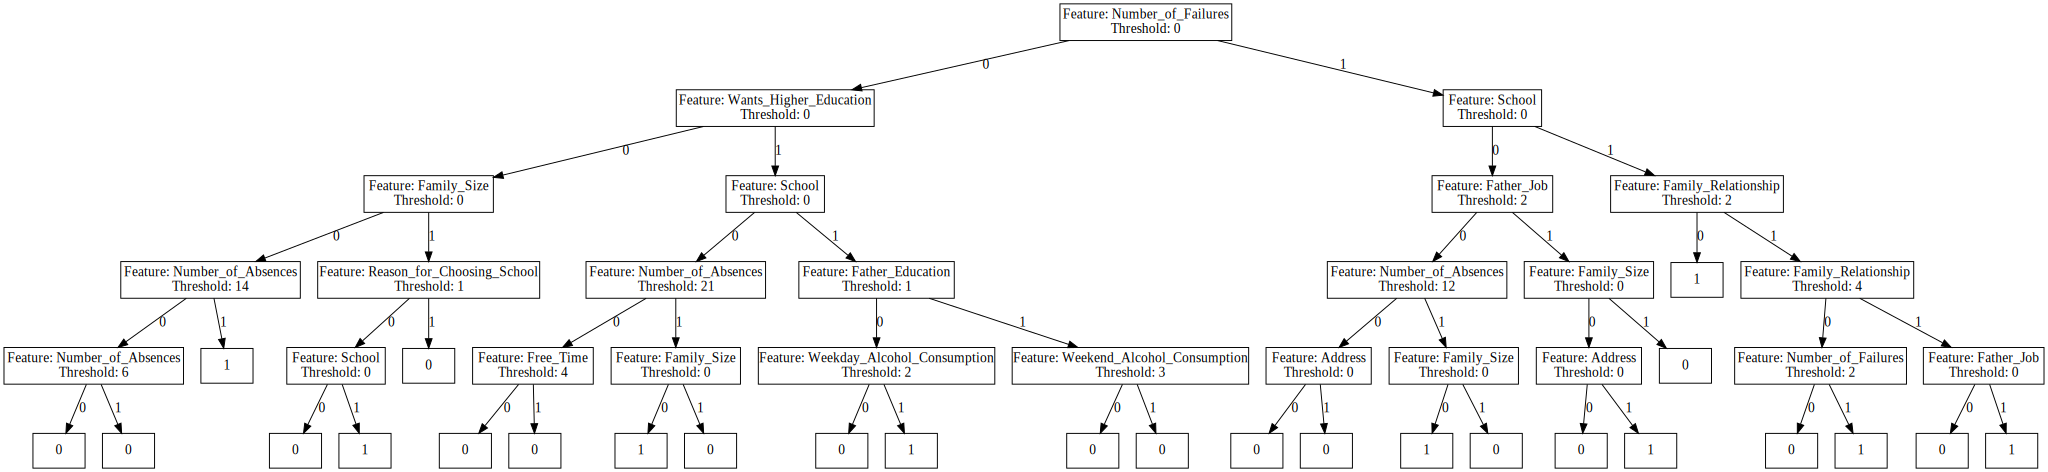

In [95]:
from graphviz import Digraph

def draw_tree(node, graph=None, parent=None, edge_label=""):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box')

    node_id = str(id(node))
    if isinstance(node, EndNode):
        graph.node(node_id, label=f"{node.resultCategory}")
    else:
        decision_info = f"Feature: {node.decision_function.feature}\nThreshold: {node.decision_function.threshold}"
        graph.node(node_id, label=f"{decision_info}")

    if parent is not None:
        graph.edge(parent, node_id, label=edge_label)

    if isinstance(node, DecisionNode):
        for edge, child in node.children.items():
            draw_tree(child, graph, node_id, edge_label=str(edge))

    return graph

# Draw the tree
tree_graph = draw_tree(root_node)
tree_graph.render("decision_tree", format="png", cleanup=True)
tree_graph